In [2]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob

%matplotlib inline

In [3]:
def list_images(images, cols = 2, rows = 6, cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: List of np.arrays compatible with plt.imshow.
            cols (Default = 2): Number of columns in the figure.
            rows (Default = 5): Number of rows in the figure.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        #Using gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape) == 2 else cmap
        img = cv2.resize(image, (480,270))
        plt.imshow(img, cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [4]:
def display_image(test_image):
    plt.figure(figsize=(10,11))
    cmap = None
    cmap = 'gray' if len(test_image.shape) == 2 else cmap
    img = cv2.resize(test_image, (480, 270))
    plt.imshow(img, cmap = cmap)
    plt.xticks([])
    plt.yticks([])
    plt.show()

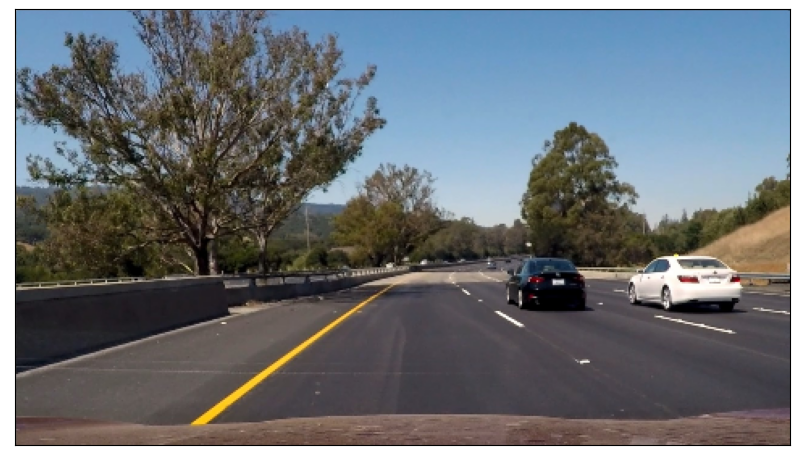

In [8]:
#Reading in the test images
test_image = plt.imread('D:/Academic stuff/MSIS Github/Mini-project-data/Curved-Lane-Lines-master/test_images/test6.jpg')
display_image(test_image)
#list_images(test_images)

In [14]:
def RGB_colour_selection(image):
    """
    Apply color selection to RGB images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #White color mask
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

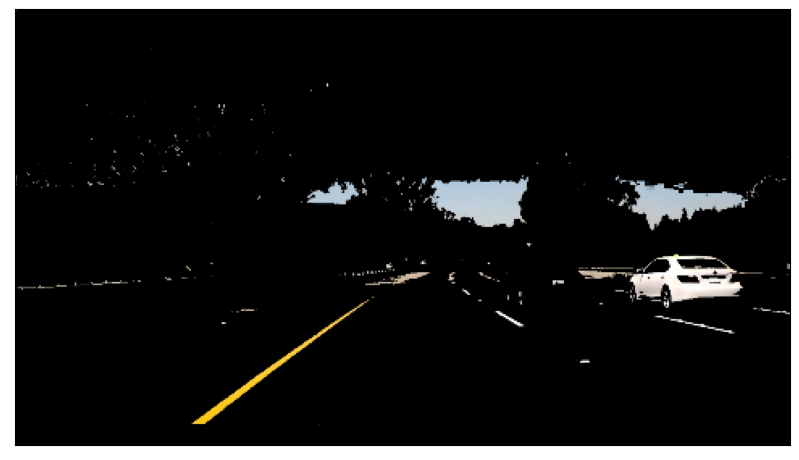

(720, 1280, 3)


In [17]:
rgb_selection = RGB_colour_selection(test_image)
display_image(rgb_selection)
print(rgb_selection.shape)

In [61]:
def create_mask(resized_img):
    ## CREATING MASK FOR THE ROAD ##
    img_mask = np.zeros(resized_img.shape[:2], dtype="uint8")
    cv2.rectangle(img_mask, (0, 720), (1280, 400), 255, -1)
    masked_img = cv2.bitwise_and(resized_img, resized_img, mask = img_mask)	 
    return masked_img

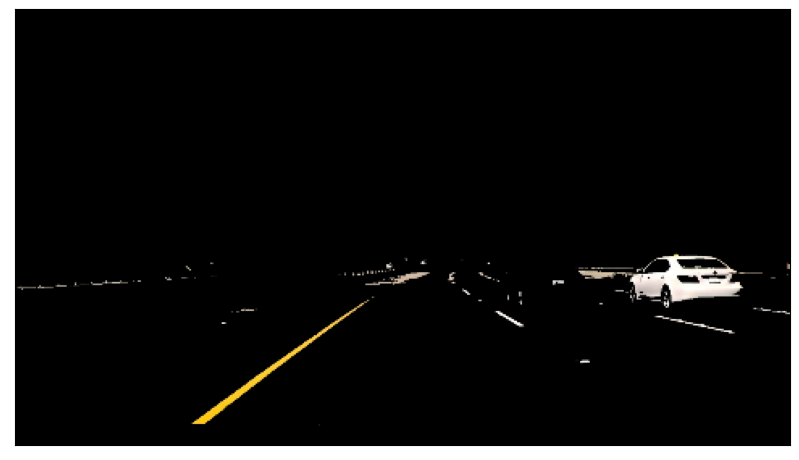

In [65]:
display_image(create_mask(rgb_selection))
rgb_selection = create_mask(rgb_selection)

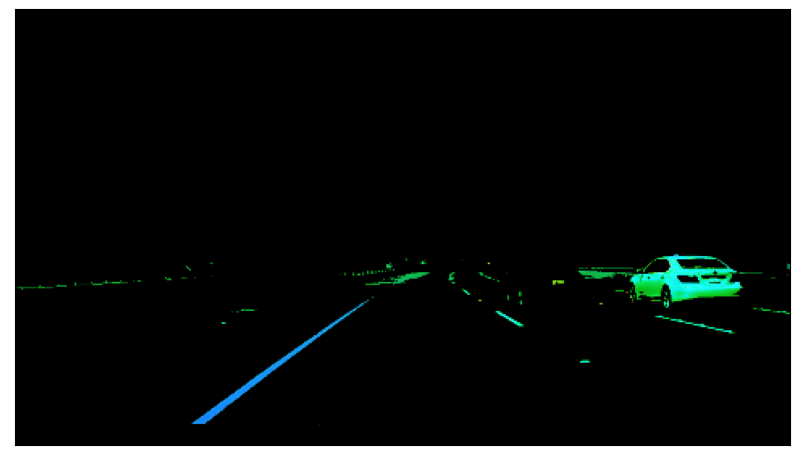

In [66]:
def convert_hsl(image):
    """
    Convert RGB images to HSL.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

display_image(convert_hsl(rgb_selection))

In [67]:
def HSL_colour_selection(image):
    """
    Apply color selection to the HSL images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSL
    converted_image = convert_hsl(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 170, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

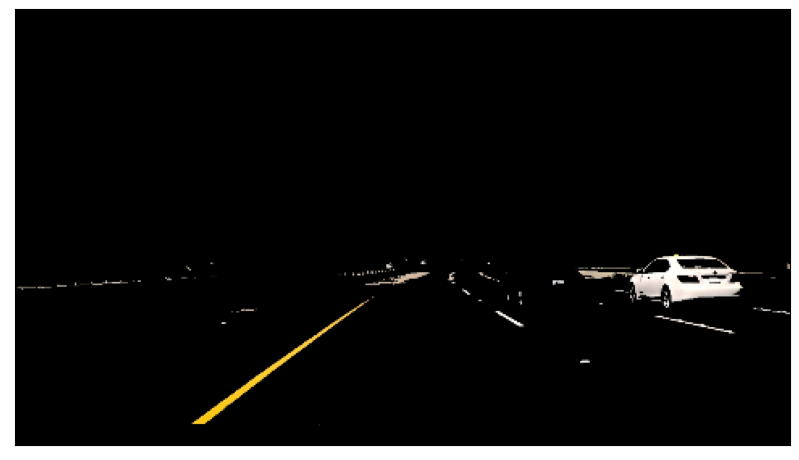

In [68]:
display_image(HSL_colour_selection(rgb_selection))

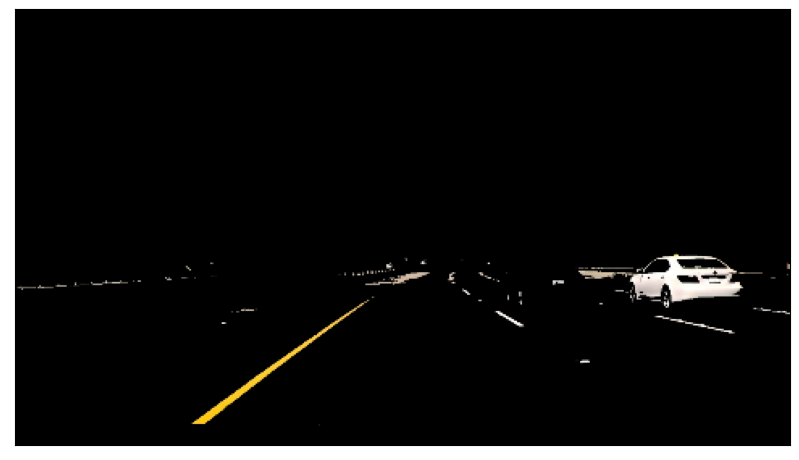

In [70]:
color_selected_image = RGB_colour_selection(rgb_selection)
display_image(RGB_colour_selection(rgb_selection))

# ***Canny Edge Detection:***
   The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images

In [71]:
#Gray scaling the images
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

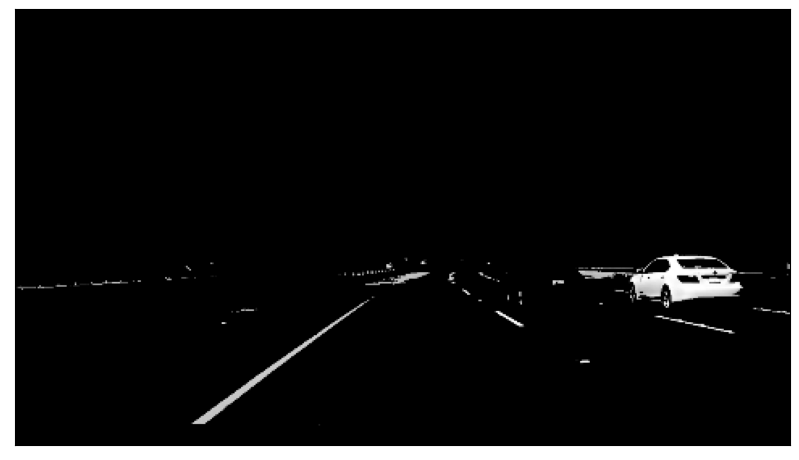

In [72]:
gray_image = gray_scale(color_selected_image)
display_image(gray_image)

In [73]:
#Applying gaussian smoothing
def gaussian_smoothing(image, kernel_size = 11):
    """
    Apply Gaussian filter to the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            kernel_size (Default = 13): The size of the Gaussian kernel will affect the performance of the detector.
            It must be an odd number (3, 5, 7, ...).
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

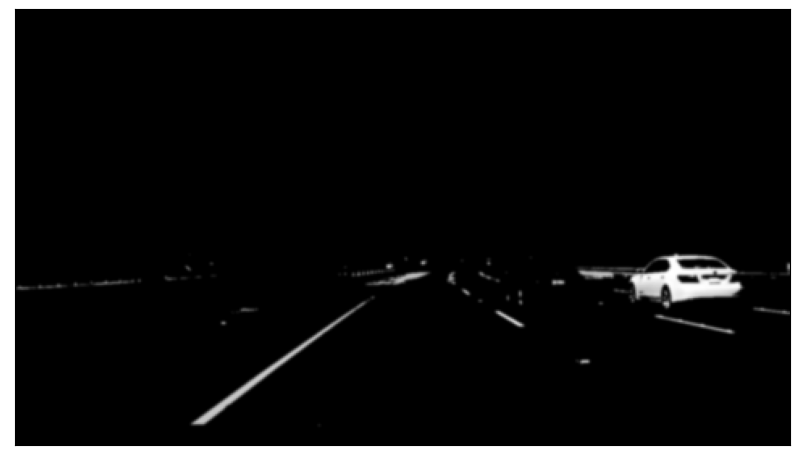

In [74]:
blur_image = gaussian_smoothing(gray_image)
display_image(blur_image)

In [75]:
#Applying canny edge detection
def canny_detector(image, low_threshold = 50, high_threshold = 170):
    """
    Apply Canny Edge Detection algorithm to the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            low_threshold (Default = 50).
            high_threshold (Default = 150).
    """
    return cv2.Canny(image, low_threshold, high_threshold)

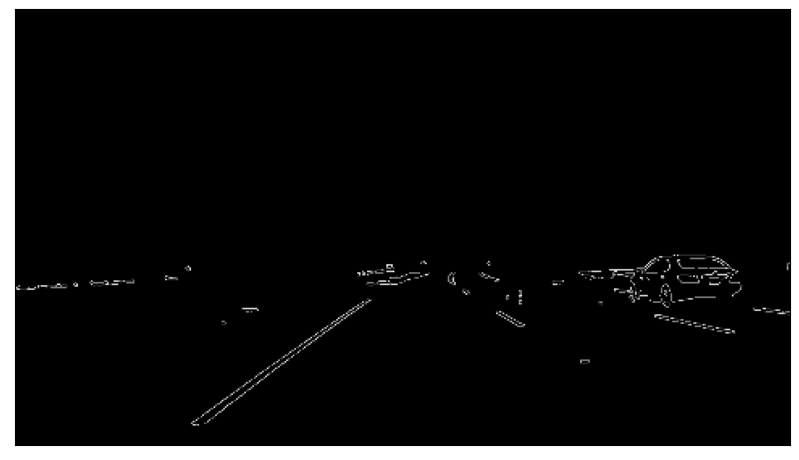

In [76]:
edge_detected_image = canny_detector(blur_image)
display_image(edge_detected_image)

In [77]:
def region_selection(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    mask = np.zeros_like(image)   
    #Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #We could have used fixed numbers as the vertices of the polygon,
    #but they will not be applicable to images with different dimesnions.
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.8]
    top_right    = [cols * 0.6, rows * 0.5]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

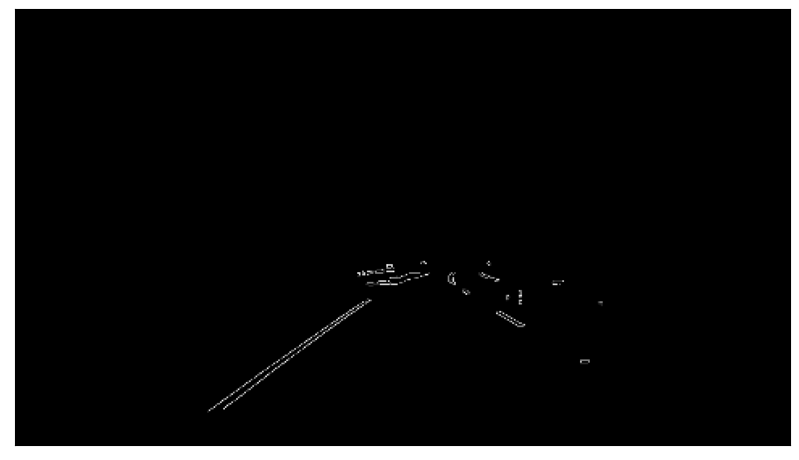

In [78]:
masked_image = region_selection(edge_detected_image)
display_image(masked_image)